In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.tsaplots as tsa_plots
from sklearn.metrics import accuracy_score,mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing dataset
air= pd.read_excel('Airlines+Data.xlsx')
air

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


## EDA

In [3]:
air.shape

(96, 2)

In [4]:
#check the datatypes
air.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [5]:
#check the descriptive statistics
air.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


In [6]:
#  information of the dataset 
air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [7]:
# check any null values is there in the dataset
air.isnull().any()

Month         False
Passengers    False
dtype: bool

In [8]:
# check any duplicated values is there
air.duplicated().sum()

0

In [9]:
#air[air.duplicated()]

## Data visualization

<Axes: xlabel='Month'>

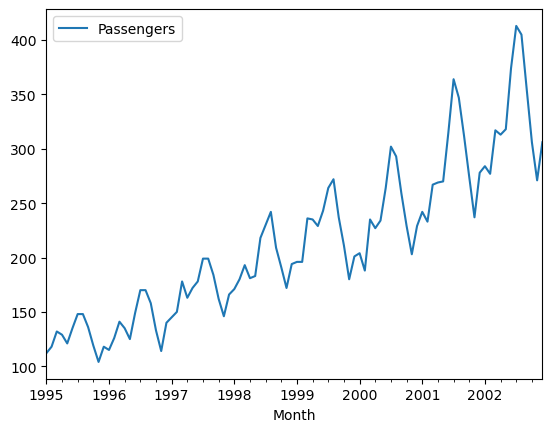

In [10]:
# plot the data
air.set_index('Month',inplace=True)

air.plot()


In [11]:
# Unique values of passangers
air['Passengers'].unique()

array([112, 118, 132, 129, 121, 135, 148, 136, 119, 104, 115, 126, 141,
       125, 149, 170, 158, 133, 114, 140, 145, 150, 178, 163, 172, 199,
       184, 162, 146, 166, 171, 180, 193, 181, 183, 218, 230, 242, 209,
       191, 194, 196, 236, 235, 229, 243, 264, 272, 237, 211, 201, 204,
       188, 227, 234, 302, 293, 259, 203, 233, 267, 269, 270, 315, 364,
       347, 312, 274, 278, 284, 277, 317, 313, 318, 374, 413, 405, 355,
       306, 271], dtype=int64)

In [12]:
result= seasonal_decompose(air['Passengers'],model='multiplicative')

<Axes: xlabel='Month'>

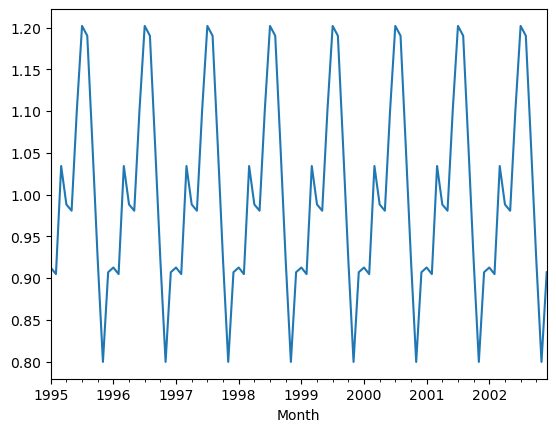

In [13]:
#plot the seasonal duration 
result.seasonal.plot()

<Axes: xlabel='Month'>

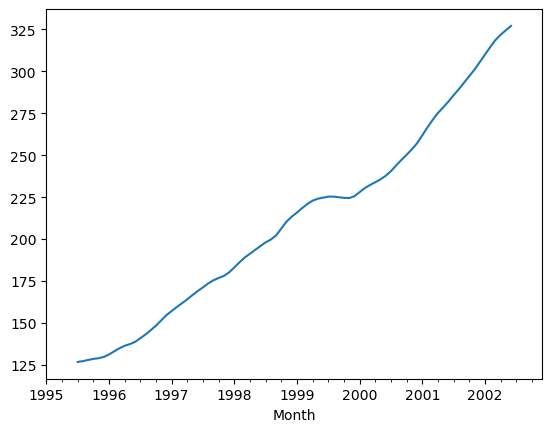

In [14]:
#plot the trend
result.trend.plot()

<Axes: xlabel='Month'>

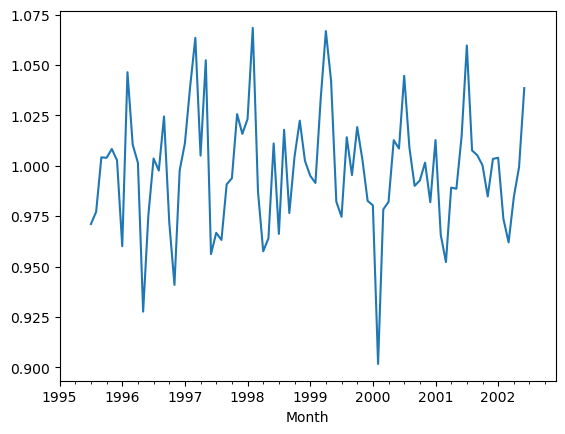

In [15]:
#plot the residuals
result.resid.plot()

In [16]:
ts_data= air['Passengers']

In [17]:
# apply log on data for removing residuals
ts_data_log= np.log(ts_data)

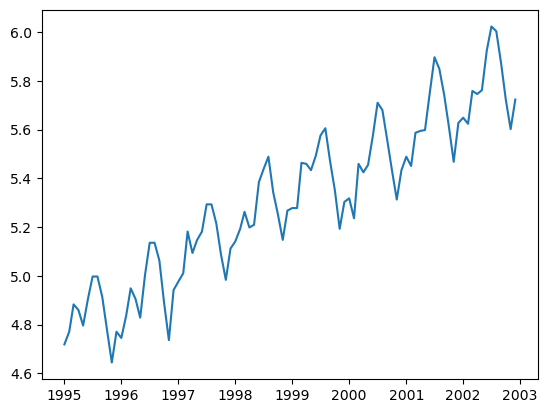

In [18]:
plt.plot(ts_data_log)

Now can see in the above graph data convert multiplicative into additive

In [19]:
#check the data is stationary or not
def test_stationarity(timeseries):
    
    #Calculate rolling mean and rolling standard deviation
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()
    
    original = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'green', label = 'Rolling Std')
    plt.legend(loc='best')
    
    
    print('Results of Dickey-Fuller Test :\n')
    df_test = adfuller(timeseries)
    my_output = pd.Series(df_test[0:4], index =['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for i,j in df_test[4].items():
        my_output['Critical Value (%s)'%i] = j
    print(my_output)

Results of Dickey-Fuller Test :

Test Statistic                  1.340248
p-value                         0.996825
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


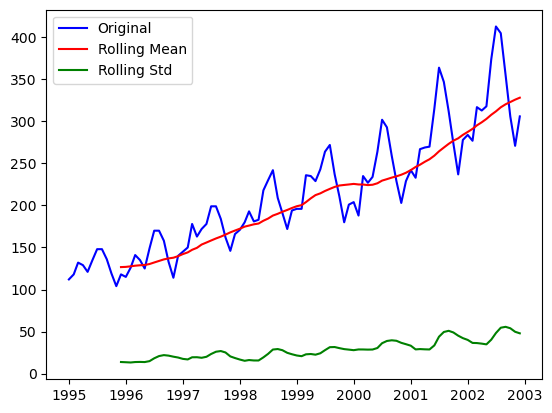

In [20]:
test_stationarity(air['Passengers'])

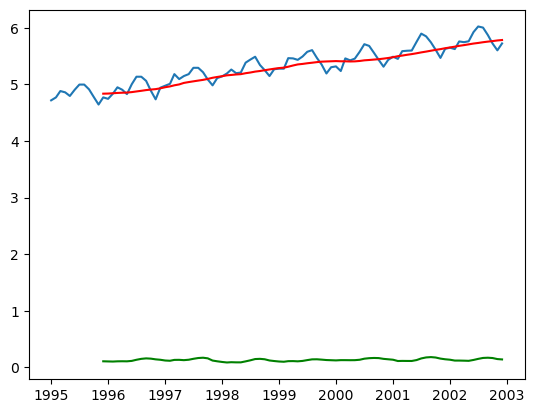

In [21]:
#moving average is- after removing residuals using np.log(data)
movingAverage = ts_data_log.rolling(window = 12).mean()
movingSTD = ts_data_log.rolling(window = 12).std()
plt.plot(ts_data_log)
plt.plot(movingAverage,color='red')
plt.plot(movingSTD,color='green')

In [22]:
#when data is not in stationarity ap
ts_data_log_diff = ts_data_log - movingAverage
ts_data_log_diff.head(15)

Month
1995-01-01         NaN
1995-02-01         NaN
1995-03-01         NaN
1995-04-01         NaN
1995-05-01         NaN
1995-06-01         NaN
1995-07-01         NaN
1995-08-01         NaN
1995-09-01         NaN
1995-10-01         NaN
1995-11-01         NaN
1995-12-01   -0.065494
1996-01-01   -0.093449
1996-02-01   -0.007566
1996-03-01    0.099416
Name: Passengers, dtype: float64

In [23]:
ts_data_log_diff.dropna(inplace=True)
ts_data_log_diff.head()

Month
1995-12-01   -0.065494
1996-01-01   -0.093449
1996-02-01   -0.007566
1996-03-01    0.099416
1996-04-01    0.052142
Name: Passengers, dtype: float64

Results of Dickey-Fuller Test :

Test Statistic                 -1.910930
p-value                         0.326937
#Lags Used                     12.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64


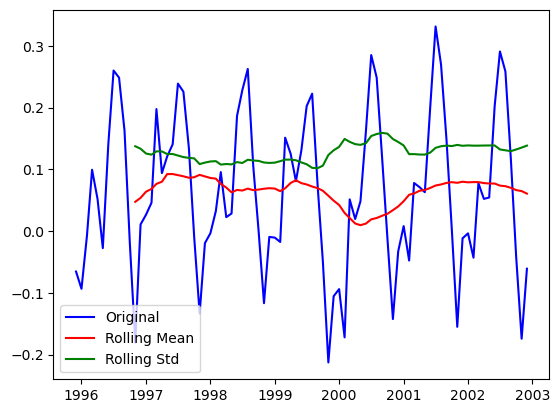

In [24]:
test_stationarity(ts_data_log_diff)

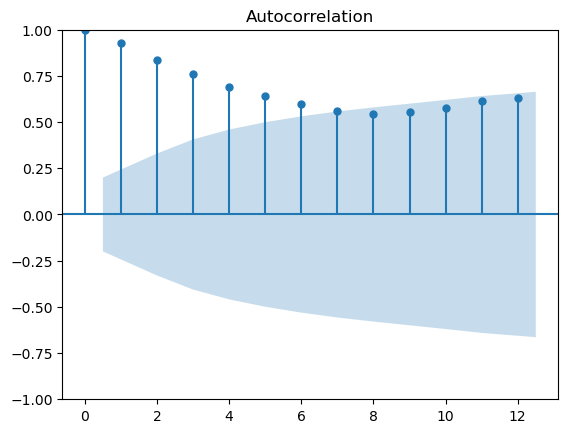

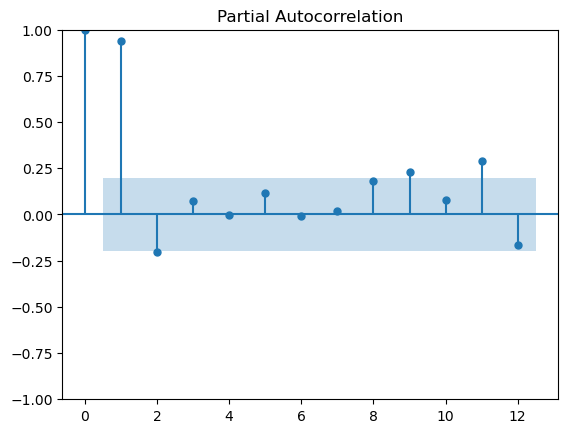

In [25]:
#import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(air.Passengers,lags=12)
tsa_plots.plot_pacf(air.Passengers,lags=12)
plt.show()

In [26]:
model = sm.tsa.arima.ARIMA(ts_data_log, order=(1,2,1))

In [27]:
results = model.fit()


In [28]:
results.forecast()

2003-01-01    5.753367
Freq: MS, dtype: float64

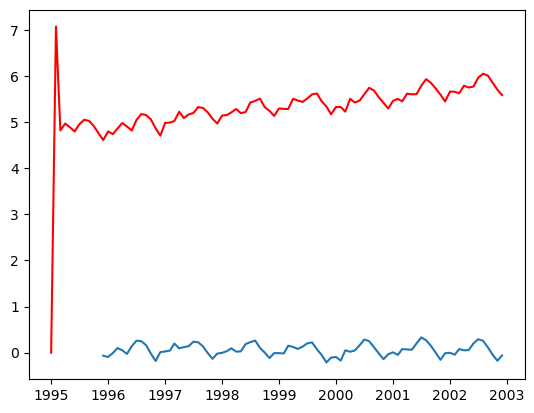

In [29]:
plt.plot(ts_data_log_diff)
plt.plot(results.fittedvalues,color='red')
plt.show()

In [30]:
Arima=results.fittedvalues
Arima

Month
1995-01-01    0.000000
1995-02-01    7.077748
1995-03-01    4.822870
1995-04-01    4.970069
1995-05-01    4.891698
                ...   
2002-08-01    6.052636
2002-09-01    6.012270
2002-10-01    5.859829
2002-11-01    5.706976
2002-12-01    5.589020
Length: 96, dtype: float64

In [31]:
air.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


In [32]:
air['T']=np.arange(1,97)
air['ts_data_log']=ts_data_log
air['ts_data_log_diff']=ts_data_log_diff
air['Arima']=Arima
air

,Passengers,T,ts_data_log,ts_data_log_diff,Arima
Month,,,,,
1995-01-01,112,1,4.718499,NaN,0.000000
1995-02-01,118,2,4.770685,NaN,7.077748
1995-03-01,132,3,4.882802,NaN,4.822870
1995-04-01,129,4,4.859812,NaN,4.970069
1995-05-01,121,5,4.795791,NaN,4.891698
...,...,...,...,...,...
2002-08-01,405,92,6.003887,0.258591,6.052636
2002-09-01,355,93,5.872118,0.116062,6.012270
2002-10-01,306,94,5.723585,-0.041675,5.859829


In [33]:
air.reset_index(inplace=True)
air

,Month,Passengers,T,ts_data_log,ts_data_log_diff,Arima
0,1995-01-01,112,1,4.718499,NaN,0.000000
1,1995-02-01,118,2,4.770685,NaN,7.077748
2,1995-03-01,132,3,4.882802,NaN,4.822870
3,1995-04-01,129,4,4.859812,NaN,4.970069
4,1995-05-01,121,5,4.795791,NaN,4.891698
...,...,...,...,...,...,...
91,2002-08-01,405,92,6.003887,0.258591,6.052636
92,2002-09-01,355,93,5.872118,0.116062,6.012270
93,2002-10-01,306,94,5.723585,-0.041675,5.859829
94,2002-11-01,271,95,5.602119,-0.174313,5.706976


In [34]:
air["month"] = air.Month.dt.strftime("%b")
month=pd.get_dummies(air['month'])
air.head()

,Month,Passengers,T,ts_data_log,ts_data_log_diff,Arima,month
0,1995-01-01,112,1,4.718499,NaN,0.000000,Jan
1,1995-02-01,118,2,4.770685,NaN,7.077748,Feb
2,1995-03-01,132,3,4.882802,NaN,4.822870,Mar
3,1995-04-01,129,4,4.859812,NaN,4.970069,Apr
4,1995-05-01,121,5,4.795791,NaN,4.891698,May


In [35]:
data1 = pd.concat([air,month],axis = 1)
data1.head()

,Month,Passengers,T,ts_data_log,ts_data_log_diff,Arima,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1995-01-01,112,1,4.718499,NaN,0.000000,Jan,0,0,0,0,1,0,0,0,0,0,0,0
1,1995-02-01,118,2,4.770685,NaN,7.077748,Feb,0,0,0,1,0,0,0,0,0,0,0,0
2,1995-03-01,132,3,4.882802,NaN,4.822870,Mar,0,0,0,0,0,0,0,1,0,0,0,0
3,1995-04-01,129,4,4.859812,NaN,4.970069,Apr,1,0,0,0,0,0,0,0,0,0,0,0
4,1995-05-01,121,5,4.795791,NaN,4.891698,May,0,0,0,0,0,0,0,0,1,0,0,0


In [36]:
data1["T_squared"] = data1["T"]*data1["T"]
data1

,Month,Passengers,T,ts_data_log,ts_data_log_diff,Arima,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,T_squared
0,1995-01-01,112,1,4.718499,NaN,0.000000,Jan,0,0,0,0,1,0,0,0,0,0,0,0,1
1,1995-02-01,118,2,4.770685,NaN,7.077748,Feb,0,0,0,1,0,0,0,0,0,0,0,0,4
2,1995-03-01,132,3,4.882802,NaN,4.822870,Mar,0,0,0,0,0,0,0,1,0,0,0,0,9
3,1995-04-01,129,4,4.859812,NaN,4.970069,Apr,1,0,0,0,0,0,0,0,0,0,0,0,16
4,1995-05-01,121,5,4.795791,NaN,4.891698,May,0,0,0,0,0,0,0,0,1,0,0,0,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,92,6.003887,0.258591,6.052636,Aug,0,1,0,0,0,0,0,0,0,0,0,0,8464
92,2002-09-01,355,93,5.872118,0.116062,6.012270,Sep,0,0,0,0,0,0,0,0,0,0,0,1,8649
93,2002-10-01,306,94,5.723585,-0.041675,5.859829,Oct,0,0,0,0,0,0,0,0,0,0,1,0,8836
94,2002-11-01,271,95,5.602119,-0.174313,5.706976,Nov,0,0,0,0,0,0,0,0,0,1,0,0,9025


<Axes: xlabel='month', ylabel='Passengers'>

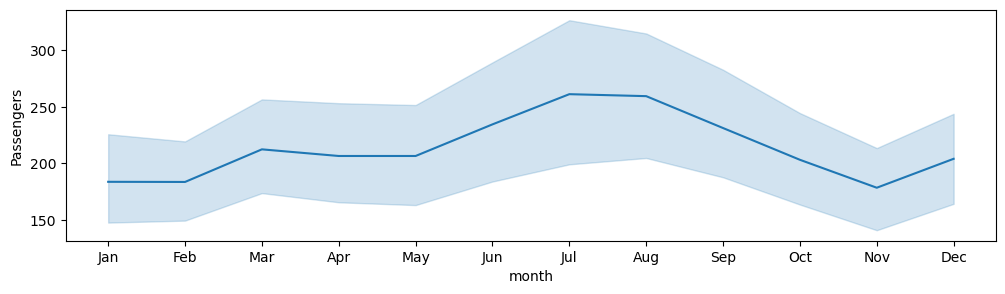

In [37]:
plt.figure(figsize=(12,3))
sns.lineplot(x="month",y="Passengers",data=data1)

In [38]:
Train = data1.head(80)
Test = data1.tail(16)

## Linear model

In [39]:
linear_model=smf.ols('Passengers~T',data=Train).fit()

In [40]:
linear_pred=pd.Series(linear_model.predict(pd.DataFrame(Test['T'])))
linear_rmse=np.sqrt(mean_squared_error(Test['Passengers'],linear_pred))
linear_rmse

47.542624067726734

In [41]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     281.2
Date:                Mon, 30 Oct 2023   Prob (F-statistic):           1.38e-27
Time:                        09:39:25   Log-Likelihood:                -375.56
No. Observations:                  80   AIC:                             755.1
Df Residuals:                      78   BIC:                             759.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    105.3392      6.048     17.416      0.000      93.298     117.381
T              2.1756      0.130     16.769      0.000       1.917       2.434
==============================================================================
Omnibus:                        5.011   Durbin-Watson:                   0.563
Prob(Omnibus):                  0.082   Jarque-Bera (JB):                4.256
Skew:                           0.463   Prob(JB):                        0.119
Kurtosis:                       3.649   Cond. No.                         94.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Exponential Model

In [42]:
Exp_model=smf.ols('ts_data_log~T',data=Train).fit()
Exp_pred=pd.Series(Exp_model.predict(pd.DataFrame(Test['T'])))
Exp_rmse=np.sqrt(mean_squared_error(Test['Passengers'],np.exp(Exp_pred)))
Exp_rmse 

43.79373939334322

In [43]:
Exp_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ts_data_log   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     350.9
Date:                Mon, 30 Oct 2023   Prob (F-statistic):           1.34e-30
Time:                        09:39:25   Log-Likelihood:                 53.563
No. Observations:                  80   AIC:                            -103.1
Df Residuals:                      78   BIC:                            -98.36
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7621      0.028    168.169      0.000       4.706       4.818
T              0.0114      0.001     18.731      0.000       0.010       0.013
==============================================================================
Omnibus:                        2.306   Durbin-Watson:                   0.660
Prob(Omnibus):                  0.316   Jarque-Bera (JB):                1.634
Skew:                          -0.135   Prob(JB):                        0.442
Kurtosis:                       2.354   Cond. No.                         94.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Arima model

In [44]:
Arima_model=smf.ols('Arima~T',data=Train).fit()
Arima_pred=pd.Series(Arima_model.predict(Test['T']))
Arima_rmse=np.sqrt(mean_squared_error(Test['Passengers'],np.exp(Arima_pred)))
Arima_rmse

51.814038551610096

In [45]:
Arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Arima   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     20.36
Date:                Mon, 30 Oct 2023   Prob (F-statistic):           2.23e-05
Time:                        09:39:25   Log-Likelihood:                -73.307
No. Observations:                  80   AIC:                             150.6
Df Residuals:                      78   BIC:                             155.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6523      0.138     33.642      0.000       4.377       4.928
T              0.0134      0.003      4.513      0.000       0.007       0.019
==============================================================================
Omnibus:                      125.644   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6875.362
Skew:                          -4.950   Prob(JB):                         0.00
Kurtosis:                      47.324   Cond. No.                         94.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Quadratic

In [46]:
Quad = smf.ols('Passengers~T+T_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["T","T_squared"]]))
rmse_Quad =np.sqrt(mean_squared_error(Test['Passengers'],pred_Quad))
rmse_Quad

43.6544036958425

In [47]:
Quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     146.6
Date:                Mon, 30 Oct 2023   Prob (F-statistic):           5.55e-27
Time:                        09:39:26   Log-Likelihood:                -373.84
No. Observations:                  80   AIC:                             753.7
Df Residuals:                      77   BIC:                             760.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    117.9532      9.079     12.992      0.000      99.874     136.032
T              1.2526      0.517      2.421      0.018       0.222       2.283
T_squared      0.0114      0.006      1.841      0.069      -0.001       0.024
==============================================================================
Omnibus:                        1.568   Durbin-Watson:                   0.586
Prob(Omnibus):                  0.457   Jarque-Bera (JB):                1.090
Skew:                           0.274   Prob(JB):                        0.580
Kurtosis:                       3.165   Cond. No.                     8.96e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Multiplicative seasonality

In [48]:
Mult_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_sea = pd.Series(Mult_sea.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_Mult_sea = np.sqrt(mean_squared_error(Test['Passengers'],(pred_Mult_sea)))
rmse_Mult_sea

129.26647641443307

In [49]:
Mult_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     1.661
Date:                Mon, 30 Oct 2023   Prob (F-statistic):              0.102
Time:                        09:39:26   Log-Likelihood:                -427.13
No. Observations:                  80   AIC:                             878.3
Df Residuals:                      68   BIC:                             906.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    174.6667     22.323      7.825      0.000     130.122     219.211
Jan           -5.3810     30.421     -0.177      0.860     -66.085      55.323
Feb           -4.5238     30.421     -0.149      0.882     -65.227      56.180
Mar           22.7619     30.421      0.748      0.457     -37.942      83.466
Apr           16.6190     30.421      0.546      0.587     -44.085      77.323
May           15.9048     30.421      0.523      0.603     -44.799      76.608
Jun           39.9048     30.421      1.312      0.194     -20.799     100.608
Jul           64.9048     30.421      2.134      0.036       4.201     125.608
Aug           64.0476     30.421      2.105      0.039       3.344     124.751
Sep           22.5000     31.569      0.713      0.478     -40.495      85.495
Oct           -0.5000     31.569     -0.016      0.987     -63.495      62.495
Nov          -21.5000     31.569     -0.681      0.498     -84.495      41.495
==============================================================================
Omnibus:                        4.649   Durbin-Watson:                   0.043
Prob(Omnibus):                  0.098   Jarque-Bera (JB):                2.521
Skew:                           0.181   Prob(JB):                        0.284
Kurtosis:                       2.210   Cond. No.                         13.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Additive seasonality

In [50]:
Add_sea = smf.ols('ts_data_log~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Add_sea = pd.Series(Add_sea.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_Add_sea = np.sqrt(mean_squared_error(Test['Passengers'],np.exp(pred_Add_sea)))
rmse_Add_sea

135.32648414621102

In [51]:
Add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ts_data_log   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     1.491
Date:                Mon, 30 Oct 2023   Prob (F-statistic):              0.155
Time:                        09:39:26   Log-Likelihood:                -5.9692
No. Observations:                  80   AIC:                             35.94
Df Residuals:                      68   BIC:                             64.52
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.1382      0.115     44.507      0.000       4.908       5.369
Jan           -0.0429      0.157     -0.273      0.786      -0.357       0.271
Feb           -0.0273      0.157     -0.174      0.863      -0.341       0.287
Mar            0.1170      0.157      0.744      0.459      -0.197       0.431
Apr            0.0813      0.157      0.517      0.607      -0.233       0.395
May            0.0716      0.157      0.455      0.651      -0.242       0.386
Jun            0.1900      0.157      1.207      0.231      -0.124       0.504
Jul            0.2972      0.157      1.889      0.063      -0.017       0.611
Aug            0.2976      0.157      1.892      0.063      -0.016       0.612
Sep            0.1214      0.163      0.743      0.460      -0.204       0.447
Oct           -0.0057      0.163     -0.035      0.972      -0.332       0.320
Nov           -0.1352      0.163     -0.828      0.410      -0.461       0.191
==============================================================================
Omnibus:                       31.181   Durbin-Watson:                   0.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                5.582
Skew:                          -0.157   Prob(JB):                       0.0614
Kurtosis:                       1.744   Cond. No.                         13.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Multiplicative seasonality Quadratic

In [52]:
Mult_sea_Quad = smf.ols('Passengers~T+T_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_Mult_sea_quad = pd.Series(Mult_sea_Quad.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','T','T_squared']]))
rmse_Mult_sea_quad = np.sqrt(mean_squared_error(Test['Passengers'],(pred_Mult_sea_quad)))
rmse_Mult_sea_quad

23.910983570106755

In [53]:
Mult_sea_Quad .summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     113.5
Date:                Mon, 30 Oct 2023   Prob (F-statistic):           7.09e-40
Time:                        09:39:26   Log-Likelihood:                -310.60
No. Observations:                  80   AIC:                             649.2
Df Residuals:                      66   BIC:                             682.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     94.6245      6.987     13.543      0.000      80.675     108.574
T              1.5119      0.256      5.897      0.000       1.000       2.024
T_squared      0.0076      0.003      2.468      0.016       0.001       0.014
Jan            3.9888      7.220      0.552      0.582     -10.426      18.404
Feb            2.7660      7.216      0.383      0.703     -11.642      17.174
Mar           27.9566      7.214      3.876      0.000      13.554      42.359
Apr           19.7034      7.212      2.732      0.008       5.305      34.102
May           16.8637      7.211      2.339      0.022       2.467      31.261
Jun           38.7231      7.211      5.370      0.000      24.326      53.120
Jul           61.5674      7.212      8.537      0.000      47.168      75.967
Aug           58.5394      7.214      8.114      0.000      44.136      72.943
Sep           28.8763      7.469      3.866      0.000      13.964      43.789
Oct            3.7660      7.468      0.504      0.616     -11.144      18.676
Nov          -19.3594      7.467     -2.593      0.012     -34.268      -4.451
==============================================================================
Omnibus:                        3.997   Durbin-Watson:                   0.577
Prob(Omnibus):                  0.136   Jarque-Bera (JB):                3.754
Skew:                           0.261   Prob(JB):                        0.153
Kurtosis:                       3.924   Cond. No.                     3.83e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.83e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Additive seasonality Quadratic

In [54]:
add_sea_Quad = smf.ols('ts_data_log~T+T_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','T','T_squared']]))
rmse_add_sea_quad = np.sqrt(mean_squared_error(Test['Passengers'],np.exp(pred_add_sea_quad)))
rmse_add_sea_quad

23.08634854615272

In [55]:
add_sea_Quad .summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ts_data_log   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     212.0
Date:                Mon, 30 Oct 2023   Prob (F-statistic):           1.72e-48
Time:                        09:39:26   Log-Likelihood:                 135.61
No. Observations:                  80   AIC:                            -243.2
Df Residuals:                      66   BIC:                            -209.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6334      0.026    175.370      0.000       4.581       4.686
T              0.0136      0.001     14.000      0.000       0.012       0.016
T_squared  -2.992e-05   1.16e-05     -2.578      0.012   -5.31e-05   -6.75e-06
Jan            0.0178      0.027      0.652      0.517      -0.037       0.072
Feb            0.0221      0.027      0.809      0.422      -0.032       0.077
Mar            0.1552      0.027      5.688      0.000       0.101       0.210
Apr            0.1082      0.027      3.968      0.000       0.054       0.163
May            0.0874      0.027      3.203      0.002       0.033       0.142
Jun            0.1946      0.027      7.137      0.000       0.140       0.249
Jul            0.2909      0.027     10.665      0.000       0.236       0.345
Aug            0.2803      0.027     10.273      0.000       0.226       0.335
Sep            0.1548      0.028      5.481      0.000       0.098       0.211
Oct            0.0165      0.028      0.585      0.560      -0.040       0.073
Nov           -0.1241      0.028     -4.396      0.000      -0.181      -0.068
==============================================================================
Omnibus:                        3.122   Durbin-Watson:                   0.712
Prob(Omnibus):                  0.210   Jarque-Bera (JB):                2.415
Skew:                          -0.297   Prob(JB):                        0.299
Kurtosis:                       3.609   Cond. No.                     3.83e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.83e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Exponential additive seasonality Model

In [56]:
Exp_sea = smf.ols('ts_data_log~T+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_exp_sea = pd.Series(Exp_sea.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','T']]))
rmse_exp_sea = np.sqrt(mean_squared_error(Test['Passengers'],np.exp(pred_exp_sea)))
rmse_exp_sea

9.469000230304077

In [57]:
Exp_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ts_data_log   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     211.3
Date:                Mon, 30 Oct 2023   Prob (F-statistic):           2.71e-48
Time:                        09:39:27   Log-Likelihood:                 131.77
No. Observations:                  80   AIC:                            -237.5
Df Residuals:                      67   BIC:                            -206.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6699      0.023    200.910      0.000       4.623       4.716
T              0.0112      0.000     45.054      0.000       0.011       0.012
Jan            0.0128      0.028      0.453      0.652      -0.044       0.069
Feb            0.0173      0.028      0.610      0.544      -0.039       0.074
Mar            0.1505      0.028      5.310      0.000       0.094       0.207
Apr            0.1036      0.028      3.657      0.001       0.047       0.160
May            0.0827      0.028      2.920      0.005       0.026       0.139
Jun            0.1900      0.028      6.705      0.000       0.133       0.247
Jul            0.2861      0.028     10.097      0.000       0.230       0.343
Aug            0.2753      0.028      9.715      0.000       0.219       0.332
Sep            0.1548      0.029      5.264      0.000       0.096       0.214
Oct            0.0166      0.029      0.564      0.575      -0.042       0.075
Nov           -0.1241      0.029     -4.220      0.000      -0.183      -0.065
==============================================================================
Omnibus:                        0.911   Durbin-Watson:                   0.641
Prob(Omnibus):                  0.634   Jarque-Bera (JB):                0.505
Skew:                          -0.177   Prob(JB):                        0.777
Kurtosis:                       3.163   Cond. No.                         611.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Compare the results

In [58]:
data = {"MODEL":pd.Series(["linear_rmse","Exp_rmse","Arima_rmse","rmse_Quad","rmse_Mult_sea","rmse_add_sea","rmse_Mult_sea_quad","rmse_add_sea_quad","rmse_exp_sea"]),
        "RMSE_Values":pd.Series([linear_rmse,Exp_rmse,Arima_rmse,rmse_Quad,rmse_Mult_sea,rmse_Add_sea,rmse_Mult_sea_quad,rmse_add_sea_quad,rmse_exp_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
8,rmse_exp_sea,9.469000
7,rmse_add_sea_quad,23.086349
6,rmse_Mult_sea_quad,23.910984
3,rmse_Quad,43.654404
1,Exp_rmse,43.793739
0,linear_rmse,47.542624
2,Arima_rmse,51.814039
4,rmse_Mult_sea,129.266476
5,rmse_add_sea,135.326484


In [59]:
np.exp(pred_exp_sea)

80    307.323808
81    270.648521
82    237.771343
83    272.199133
84    278.808336
85    283.189950
86    327.170631
87    315.686737
88    312.633514
89    351.916335
90    391.762817
91    391.909918
92    351.324969
93    309.398688
94    271.814312
95    311.171310
dtype: float64

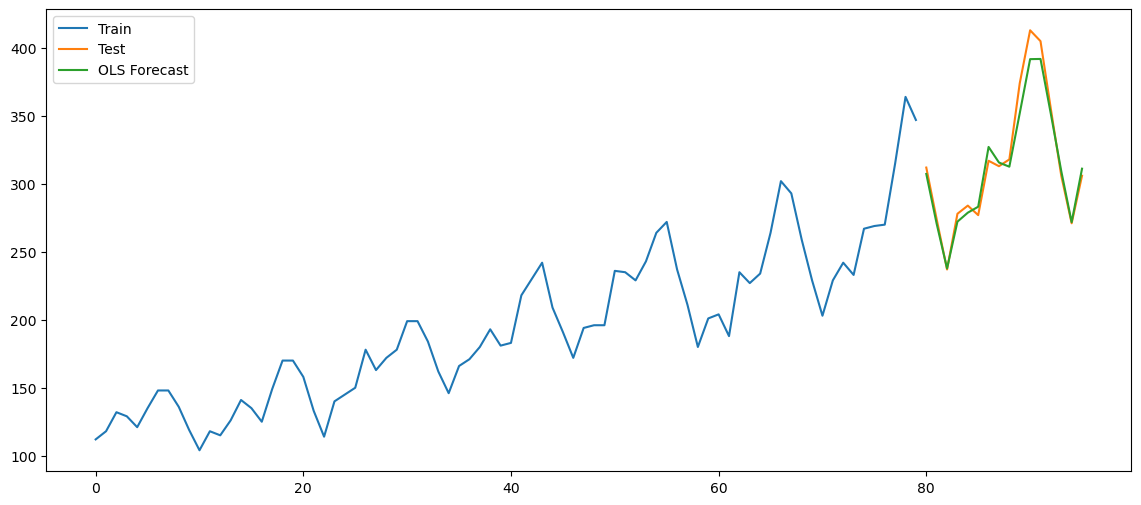

In [60]:
plt.figure(figsize=(14,6))
plt.plot(Train['Passengers'], label='Train')
plt.plot(Test['Passengers'], label='Test')
plt.plot(np.exp(pred_exp_sea), label='OLS Forecast')
plt.legend(loc='best')
plt.show()


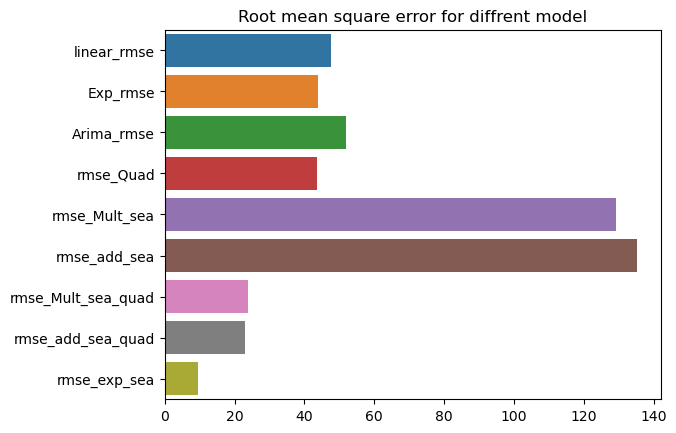

In [61]:
sns.barplot(y=data['MODEL'],x=data['RMSE_Values'],data=table_rmse)
plt.title('Root mean square error for diffrent model');

## Ordinary Least Sqaured with Exponential Additive Seasonality:

## The best model we have got so far with the lowest RMSE.